In [47]:
import torch
# GPU 사용 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
print(torch.cuda.get_device_name(0))

# CUDA 사용 가능 여부 확인
print(f"CUDA available: {torch.cuda.is_available()}")  # True여야 함

# PyTorch에서 사용하는 CUDA 버전 확인
print(f"CUDA version in PyTorch: {torch.version.cuda}")

cuda
NVIDIA GeForce RTX 4050 Laptop GPU
CUDA available: True
CUDA version in PyTorch: 11.8


In [2]:
# 라이브러리 임포트
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import albumentations as A
import matplotlib.pyplot as plt

In [3]:
# 하이퍼파라미터 설정
IMAGE_SIZE = 64
BATCH_SIZE = 64
N_EPOCHS = 20

# 이미지 전처리
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

In [4]:
import os
print(os.getcwd())

d:\sy\code


In [5]:
# 데이터세트 디렉토리 설정
original_dir = '../PCB_imgs/all'
original_dataset = ImageFolder(root=original_dir, transform=transform)

# 데이터세트 DataLoader로 변환
original_loader = DataLoader(original_dataset, batch_size=BATCH_SIZE, shuffle=True)

# 데이터 분할
file_paths = [img[0] for img in original_dataset.imgs]
targets = original_dataset.targets

train_images, test_images, train_targets, test_targets = train_test_split(
    file_paths, targets, stratify=targets, test_size=0.2, random_state=124
)

train_images, validation_images, train_targets, validation_targets = train_test_split(
    train_images, train_targets, stratify=train_targets, test_size=0.2, random_state=124
)

# DataFrame 생성
train_df = pd.DataFrame({'file_paths': train_images, 'targets': train_targets})
validation_df = pd.DataFrame({'file_paths': validation_images, 'targets': validation_targets})
test_df = pd.DataFrame({'file_paths': test_images, 'targets': test_targets})

In [6]:
# 각 클래스의 이미지 수 확인
print(f'train_ng: {sum(train_df['targets'] == 0)}개')  # 0이 ng 클래스인 경우
print(f'train_ok: {sum(train_df['targets'] == 1)}개')  # 1이 ok 클래스인 경우
print(f'test_ng: {sum(test_df['targets'] == 0)}개') 
print(f'test_ok: {sum(test_df['targets'] == 1)}개') 
print(f'val_ng: {sum(validation_df['targets'] == 0)}개') 
print(f'val_ok: {sum(validation_df['targets'] == 1)}개')  

train_ng: 1178개
train_ok: 830개
test_ng: 368개
test_ok: 260개
val_ng: 294개
val_ok: 208개


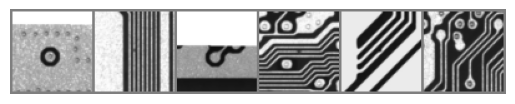

OK    NG    OK    NG    NG    OK   


In [33]:
classes = ('NG', 'OK')

# 이미지를 보여주기 위한 함수
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')  # 축 숨기기
    plt.show()

# 이미지를 무작위로 가져오기
dataiter = iter(original_loader)
images, labels = next(dataiter)

# 6개의 이미지와 레이블만 가져오기
images = images[:6]  # 첫 6개 이미지
labels = labels[:6]  # 첫 6개 레이블

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(len(labels))))  # labels의 길이에 따라 반복

In [44]:
# 커스텀 데이터세트 정의
class CustomDataset(Dataset):
    def __init__(self, file_paths, targets, aug=None, preprocess=None):
        self.file_paths = file_paths
        self.targets = targets
        self.aug = aug
        self.preprocess = preprocess

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        file_path = self.file_paths[index]
        target = self.targets[index]
        
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))

        if self.aug is not None:
            image = self.aug(image=image)['image']

        if self.preprocess is not None:
            image = self.preprocess(image)

        image = np.transpose(image, (2, 0, 1))  # (H, W, C) -> (C, H, W)
        image = torch.tensor(image, dtype=torch.float32)
        
        return image, target

In [8]:
# # 데이터 증강 정의
# aug = A.Compose([
#     A.ShiftScaleRotate(p=0.5),
#     A.HorizontalFlip(p=0.5),
#     A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0, p=0.5)
# ])

In [9]:
# 데이터세트 인스턴스 생성
# train_dataset = CustomDataset(train_df['file_paths'].values, train_df['targets'].values, aug=aug)
train_dataset = CustomDataset(train_df['file_paths'].values, train_df['targets'].values)
validation_dataset = CustomDataset(validation_df['file_paths'].values, validation_df['targets'].values)
test_dataset = CustomDataset(test_df['file_paths'].values, test_df['targets'].values)

In [45]:
# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [46]:
# 모델 정의
class CustomModel(nn.Module):
    def __init__(self, model_name='vgg16'):
        super(CustomModel, self).__init__()
        if model_name == 'vgg16':
            self.base_model = torchvision.models.vgg16(weights='IMAGENET1K_V1')
            self.base_model.classifier = nn.Identity()  # 마지막 분류기 제거
        elif model_name == 'resnet50':
            self.base_model = torchvision.models.resnet50(weights='IMAGENET1K_V1')
            self.base_model = nn.Sequential(*list(self.base_model.children())[:-1])  # 마지막 레이어 제거
        elif model_name == 'inception':
            self.base_model = torchvision.models.inception_v3(weights='IMAGENET1K_V1')
            self.base_model.classifier = nn.Identity()  # 마지막 분류기 제거
        elif model_name == 'mobilenet':
            self.base_model = torchvision.models.mobilenet_v2(weights='IMAGENET1K_V1')
            self.base_model.classifier = nn.Identity()  # 마지막 분류기 제거

        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(self._get_features_dim(model_name), 50)
        self.fc2 = nn.Linear(50, 1)  # Sigmoid 출력

    def _get_features_dim(self, model_name):
        if model_name in ['vgg16', 'inception']:
            return 25088  # VGG16의 출력 차원
        elif model_name == 'resnet50':
            return 2048  # ResNet50의 출력 차원
        elif model_name == 'mobilenet':
            return 1280  # MobileNetV2의 출력 차원

    def forward(self, x):
        x = self.base_model(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(x)
        x = nn.ReLU()(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # Sigmoid 제거
        # x = torch.sigmoid(self.fc2(x))
        return x

In [47]:
# 모델 초기화
model = CustomModel(model_name='resnet50').to(device)

In [48]:
# 손실 함수 및 최적화함수 정의
criterion = nn.BCEWithLogitsLoss()  # 이진 교차 엔트로피 손실
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Adam 옵티마이저

In [49]:
# 평가 함수 정의
def evaluate_model(model, data_loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, targets in data_loader:
            images, targets = images.to(device), targets.to(device).float()
            outputs = model(images)
            loss = criterion(outputs.view(-1), targets)
            total_loss += loss.item()
            
            predicted = (outputs.view(-1) > 0.5).float()
            correct += (predicted == targets).sum().item()
            total += targets.size(0)

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy

In [50]:
# 모델 훈련
for epoch in range(N_EPOCHS):
    model.train()
    running_loss = 0.0
    correct_predictions = 0  # 정확도 계산을 위한 변수
    total_predictions = 0    # 전체 샘플 수

    for images, targets in train_loader:
        images, targets = images.to(device), targets.to(device).float()
        
        optimizer.zero_grad()
        outputs = model(images)

        # 손실 계산
        loss = criterion(outputs.view(-1), targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # 정확도 계산
        predicted = (torch.sigmoid(outputs.view(-1)) > 0.5).float()  # 확률을 0.5 기준으로 이진 분류
        correct_predictions += (predicted == targets).sum().item()
        total_predictions += targets.size(0)

    # 훈련 데이터 정확도
    train_accuracy = correct_predictions / total_predictions

    # 검증
    val_loss, val_accuracy = evaluate_model(model, validation_loader, criterion)

    print(f'Epoch [{epoch+1}/{N_EPOCHS}], Train Loss: {running_loss / len(train_loader):.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

Epoch [1/20], Train Loss: 0.5310, Train Accuracy: 0.7385, Val Loss: 0.3989, Val Accuracy: 0.7749
Epoch [2/20], Train Loss: 0.3600, Train Accuracy: 0.8162, Val Loss: 0.3059, Val Accuracy: 0.8625
Epoch [3/20], Train Loss: 0.3046, Train Accuracy: 0.8710, Val Loss: 0.2564, Val Accuracy: 0.8884
Epoch [4/20], Train Loss: 0.2469, Train Accuracy: 0.8964, Val Loss: 0.2735, Val Accuracy: 0.8984
Epoch [5/20], Train Loss: 0.2064, Train Accuracy: 0.9203, Val Loss: 0.2016, Val Accuracy: 0.9323
Epoch [6/20], Train Loss: 0.1663, Train Accuracy: 0.9373, Val Loss: 0.2459, Val Accuracy: 0.9163
Epoch [7/20], Train Loss: 0.1446, Train Accuracy: 0.9492, Val Loss: 0.2505, Val Accuracy: 0.9104
Epoch [8/20], Train Loss: 0.1738, Train Accuracy: 0.9363, Val Loss: 0.2346, Val Accuracy: 0.9124
Epoch [9/20], Train Loss: 0.1311, Train Accuracy: 0.9482, Val Loss: 0.2559, Val Accuracy: 0.9124
Epoch [10/20], Train Loss: 0.1296, Train Accuracy: 0.9542, Val Loss: 0.2686, Val Accuracy: 0.9064
Epoch [11/20], Train Loss: 0.

In [52]:
# 테스트 데이터세트로 평가
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.2449, Test Accuracy: 0.9283


mobilenet 모델

In [23]:
# 모델 초기화
model = CustomModel(model_name='mobilenet').to(device)

In [24]:
# 손실 함수 및 최적화함수 정의
criterion = nn.BCEWithLogitsLoss()  # 이진 교차 엔트로피 손실
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Adam 옵티마이저

In [34]:
# 모델 훈련
for epoch in range(N_EPOCHS):
    model.train()
    running_loss = 0.0
    correct_predictions = 0  # 정확도 계산을 위한 변수
    total_predictions = 0    # 전체 샘플 수

    for images, targets in train_loader:
        images, targets = images.to(device), targets.to(device).float()
        
        optimizer.zero_grad()
        outputs = model(images)

        # 손실 계산
        loss = criterion(outputs.view(-1), targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # 정확도 계산
        predicted = (torch.sigmoid(outputs.view(-1)) > 0.5).float()  # 확률을 0.5 기준으로 이진 분류
        correct_predictions += (predicted == targets).sum().item()
        total_predictions += targets.size(0)

    # 훈련 데이터 정확도
    train_accuracy = correct_predictions / total_predictions

    # 검증
    val_loss, val_accuracy = evaluate_model(model, validation_loader, criterion)

    print(f'Epoch [{epoch+1}/{N_EPOCHS}], Train Loss: {running_loss / len(train_loader):.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

Epoch [1/20], Train Loss: 0.0093, Train Accuracy: 0.9965, Val Loss: 0.4605, Val Accuracy: 0.9064
Epoch [2/20], Train Loss: 0.0150, Train Accuracy: 0.9955, Val Loss: 0.4782, Val Accuracy: 0.8964
Epoch [3/20], Train Loss: 0.0181, Train Accuracy: 0.9935, Val Loss: 0.4725, Val Accuracy: 0.9084
Epoch [4/20], Train Loss: 0.0104, Train Accuracy: 0.9965, Val Loss: 0.4673, Val Accuracy: 0.9104
Epoch [5/20], Train Loss: 0.0141, Train Accuracy: 0.9960, Val Loss: 0.4270, Val Accuracy: 0.9263
Epoch [6/20], Train Loss: 0.0141, Train Accuracy: 0.9950, Val Loss: 0.4540, Val Accuracy: 0.9163
Epoch [7/20], Train Loss: 0.0264, Train Accuracy: 0.9945, Val Loss: 0.4063, Val Accuracy: 0.9183
Epoch [8/20], Train Loss: 0.0156, Train Accuracy: 0.9955, Val Loss: 0.3588, Val Accuracy: 0.9283
Epoch [9/20], Train Loss: 0.0069, Train Accuracy: 0.9980, Val Loss: 0.3427, Val Accuracy: 0.9363
Epoch [10/20], Train Loss: 0.0041, Train Accuracy: 0.9990, Val Loss: 0.3589, Val Accuracy: 0.9263
Epoch [11/20], Train Loss: 0.

In [35]:
# 테스트 데이터세트로 평가
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.3467, Test Accuracy: 0.9379


데이터 증강을 해보자..  
일단 훈련 손실값은 계속 낮아지지만 검증 손실값이 오르락 내리락하는군..

In [36]:
# # 데이터 증강 정의
aug = A.Compose([
    A.ShiftScaleRotate(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0, p=0.5)
])

# 데이터세트 인스턴스 생성
train_dataset = CustomDataset(train_df['file_paths'].values, train_df['targets'].values, aug=aug)
validation_dataset = CustomDataset(validation_df['file_paths'].values, validation_df['targets'].values)
test_dataset = CustomDataset(test_df['file_paths'].values, test_df['targets'].values)

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [37]:
# 모델 초기화
model = CustomModel(model_name='mobilenet').to(device)

In [38]:
# 손실 함수 및 최적화함수 정의
criterion = nn.BCEWithLogitsLoss()  # 이진 교차 엔트로피 손실
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Adam 옵티마이저

In [39]:
# 모델 훈련
for epoch in range(N_EPOCHS):
    model.train()
    running_loss = 0.0
    correct_predictions = 0  # 정확도 계산을 위한 변수
    total_predictions = 0    # 전체 샘플 수

    for images, targets in train_loader:
        images, targets = images.to(device), targets.to(device).float()
        
        optimizer.zero_grad()
        outputs = model(images)

        # 손실 계산
        loss = criterion(outputs.view(-1), targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # 정확도 계산
        predicted = (torch.sigmoid(outputs.view(-1)) > 0.5).float()  # 확률을 0.5 기준으로 이진 분류
        correct_predictions += (predicted == targets).sum().item()
        total_predictions += targets.size(0)

    # 훈련 데이터 정확도
    train_accuracy = correct_predictions / total_predictions

    # 검증
    val_loss, val_accuracy = evaluate_model(model, validation_loader, criterion)

    print(f'Epoch [{epoch+1}/{N_EPOCHS}], Train Loss: {running_loss / len(train_loader):.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

Epoch [1/20], Train Loss: 0.5816, Train Accuracy: 0.6927, Val Loss: 0.4305, Val Accuracy: 0.7789
Epoch [2/20], Train Loss: 0.4323, Train Accuracy: 0.7953, Val Loss: 0.3627, Val Accuracy: 0.8008
Epoch [3/20], Train Loss: 0.3643, Train Accuracy: 0.8362, Val Loss: 0.3355, Val Accuracy: 0.8466
Epoch [4/20], Train Loss: 0.3286, Train Accuracy: 0.8421, Val Loss: 0.2983, Val Accuracy: 0.8865
Epoch [5/20], Train Loss: 0.2895, Train Accuracy: 0.8685, Val Loss: 0.2763, Val Accuracy: 0.8805
Epoch [6/20], Train Loss: 0.2811, Train Accuracy: 0.8835, Val Loss: 0.2569, Val Accuracy: 0.9024
Epoch [7/20], Train Loss: 0.2413, Train Accuracy: 0.8994, Val Loss: 0.2505, Val Accuracy: 0.9143
Epoch [8/20], Train Loss: 0.2324, Train Accuracy: 0.9034, Val Loss: 0.2712, Val Accuracy: 0.8904
Epoch [9/20], Train Loss: 0.2013, Train Accuracy: 0.9213, Val Loss: 0.2594, Val Accuracy: 0.9044
Epoch [10/20], Train Loss: 0.1833, Train Accuracy: 0.9258, Val Loss: 0.2639, Val Accuracy: 0.9044
Epoch [11/20], Train Loss: 0.

In [40]:
# 테스트 데이터세트로 평가
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.2799, Test Accuracy: 0.9092


resnet50  
Epoch [20/20], Train Loss: 0.0688, Train Accuracy: 0.9746, Val Loss: 0.2381, Val Accuracy: 0.9303    

mobilenet   
Epoch [20/20], Train Loss: 0.0012, Train Accuracy: 0.9995, Val Loss: 0.4009, Val Accuracy: 0.9243    

mobilenet 데이터 증강 후  
Epoch [20/20], Train Loss: 0.1009, Train Accuracy: 0.9622, Val Loss: 0.3000, Val Accuracy: 0.9124

#### NG 이미지 특성 확인해보기  

In [14]:
# ng 폴더내 이미지가 왜 결함이 있는지 이름에 따라 나눠볼 수 있을 듯.
# 먼저 파일이름으로 몇종류의 결함이 있는지 확인해보기

# 이미지 명이 '결함명 (이미지 번호).bmp.bmp' 또는 '결함명_이미지 번호.bmp.bmp' 로 되어있는 것을 확인.
# 적절한 결함명만 추출해보자 (중복 제외)
import os
import re

# NG 폴더 경로
ng_root = '../PCB_imgs/all/NG/'

# 파일 이름에서 결함명 추출 함수
def extract_defect_names(folder_path):
    # 폴더 내 파일 리스트 불러오기
    files = os.listdir(folder_path)
    
    # 결함명을 저장할 집합 (중복 방지, 소문자로 변환)
    defect_names = set()
    
    # 파일명 패턴 분석 (결함명 추출)
    # 결함명(숫자) 또는 결함명_숫자 형식의 파일명 대응
    pattern = re.compile(r'([가-힣a-zA-Z]+)[_\s]?\(?\d+\)?\.bmp\.bmp')

    for file_name in files:
        match = pattern.match(file_name)
        if match:
            defect_name = match.group(1).lower()  # 결함명을 소문자로 변환하여 중복 제거
            defect_names.add(defect_name)
    
    return defect_names

# NG 폴더에서 결함명 추출
defect_names = extract_defect_names(ng_root)
print(defect_names)


{'eemool', 'open', 'nogwang', 'miboo', 'miboosik', 'dust', 'pinhole', 'milchack', 'lvh', 'nick', 'island', 'chui', 'short', 'bichim', 'pyomyun', 'scratch'}


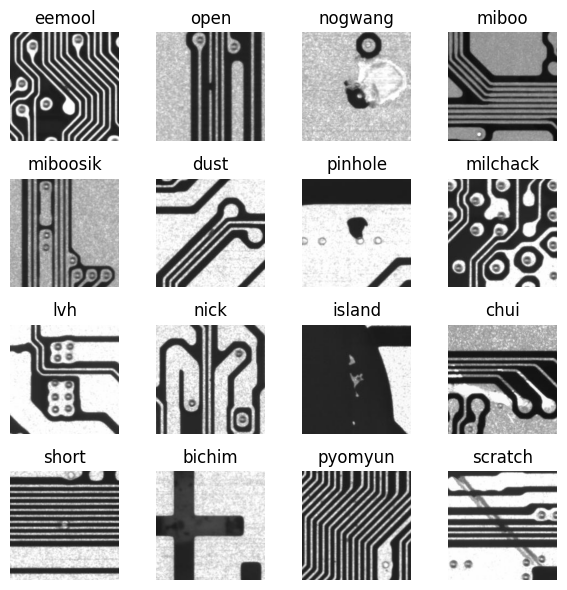

{'eemool', 'open', 'nogwang', 'miboo', 'miboosik', 'dust', 'pinhole', 'milchack', 'lvh', 'nick', 'island', 'chui', 'short', 'bichim', 'pyomyun', 'scratch'}


In [139]:
# ng 폴더내 이미지가 왜 결함이 있는지 이름에 따라 나눠볼 수 있을 듯.
# 먼저 파일이름으로 몇종류의 결함이 있는지 확인해보기

# 이미지 명이 '결함명 (이미지 번호).bmp.bmp' 또는 '결함명_이미지 번호.bmp.bmp' 로 되어있는 것을 확인.
# 적절한 결함명만 추출해보자 (중복 제외)
import os
import re
import random
from PIL import Image
import matplotlib.pyplot as plt

# NG 폴더 경로
ng_root = '../PCB_imgs/all/NG/'

# 파일 이름에서 결함명 추출 함수
def extract_defect_names(folder_path):
    # 폴더 내 파일 리스트 불러오기
    files = os.listdir(folder_path)
    
    # 결함명을 저장할 집합 (중복 방지, 소문자로 변환)
    defect_names = set()
    
    # 파일명 패턴 분석 (결함명 추출)
    pattern = re.compile(r'([a-zA-Z]+)[_\s]?\(?\d+\)?\.bmp\.bmp')

    for file_name in files:
        match = pattern.match(file_name)
        if match:
            defect_name = match.group(1).lower()  # 결함명을 소문자로 변환
            defect_names.add(defect_name)
    
    return defect_names

# 결함명과 해당 이미지 목록을 저장할 딕셔너리 생성
defect_images = {}

# NG 폴더에서 결함명 추출 및 해당 이미지 수집
defect_names = extract_defect_names(ng_root)

for defect in defect_names:
    # 결함명으로 해당하는 이미지 파일 목록 생성
    defect_images[defect] = [f for f in os.listdir(ng_root) if defect in f]

# 각 결함 유형에서 랜덤으로 하나의 이미지를 시각화 (4x4)
def visualize_defect_images(defect_images):
    # 최대 16개 이미지
    images_to_show = []
    for defect, images in defect_images.items():
        if len(images) > 0: 
            # 랜덤으로 하나의 이미지 선택
            image_file = random.choice(images)
            image_path = os.path.join(ng_root, image_file)

            images_to_show.append((defect, Image.open(image_path)))

    # 4x4 그리드로 시각화
    plt.figure(figsize=(6, 6))
    num_images = min(16, len(images_to_show))
    for i in range(num_images):
        defect, image = images_to_show[i]
        plt.subplot(4, 4, i + 1)
        plt.imshow(image)
        plt.title(defect)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# 결함 이미지 시각화
visualize_defect_images(defect_images)
print(defect_names)

eemool: 아마도 **"이물"**을 의미할 수 있습니다. 이물질이 PCB 위에 남아 있는 결함으로, 외부 오염 또는 제조 과정에서 발생할 수 있는 먼지, 파편 등을 말합니다.  

open: **"오픈 회로"**를 의미합니다. PCB의 트레이스가 단절되거나 연결되지 않아 회로가 열려 있는 상태로, 전류가 흐르지 않는 결함입니다.  

nogwang: 아마도 **"노광"**을 의미할 수 있습니다. 이는 PCB 제조 시 노광(사진 이미지 처리 과정) 문제로 인해 발생하는 결함을 뜻할 수 있습니다.  

miboo: **"미부"**로 추정됩니다. **미부(미부착)**는 특정 부품이나 소재가 제대로 부착되지 않은 경우를 의미할 수 있습니다.  

miboosik: **"미부식"**으로 보입니다. 미부식은 PCB 표면이 제대로 부식되지 않았거나 부식이 부족한 상태를 의미할 수 있습니다.  

dust: **"먼지"**를 뜻합니다. 이물질이 PCB에 붙어 있는 결함으로, 먼지로 인한 표면 오염을 의미할 수 있습니다.  

pinhole: "핀홀" 결함은 매우 작은 구멍이 PCB 트레이스 또는 납땜된 부위에 생긴 결함을 의미합니다. 제조 공정 중 불완전한 납땜이나 불균일한 코팅으로 인해 발생할 수 있습니다.  

milchack: "밀착" 문제로 보입니다. PCB 부품이 제대로 밀착되지 않았을 때 발생하는 결함일 수 있습니다.  
 
lvh: **"LVH"**는 Laser Via Hole의 약어일 가능성이 높습니다. 이는 PCB에서 레이저로 만든 미세 구멍(Via) 관련 결함을 의미할 수 있습니다.  

nick: **"니크"**는 작은 긁힘이나 칩 등이 발생한 결함을 의미할 수 있습니다. 물리적 손상으로 인한 표면 손상일 수 있습니다.  

island: "섬" 결함은 PCB의 전도층에서 트레이스가 끊어져 섬처럼 남아 있는 결함을 나타낼 수 있습니다.  

chui: **"취"**는 아마도 취부(납땜 결함)와 관련 있을 수 있습니다. 납땜이 잘못되거나 불완전하게 이루어진 결함을 의미할 수 있습니다.  

short: **"쇼트"**는 단락 결함입니다. 두 개의 전기 회로가 의도치 않게 연결되어 단락(short)이 발생하는 상황을 의미합니다.  

bichim: **"비침"**으로, PCB 기판의 패턴이 잘못 인쇄되어 아래층이 비치는 결함을 의미할 수 있습니다.  

pyomyun: "표면" 결함으로 보입니다. PCB 표면에 균열, 긁힘 등이 발생한 결함을 의미할 수 있습니다.  

scratch: "스크래치" 결함은 PCB 표면에 긁힘이나 손상이 생긴 결함을 의미합니다.  

#### .bmp vs .png 확장자?    
  
1. 파일 형식 및 압축  
BMP (Bitmap): BMP는 비압축 이미지 형식입니다. 이는 파일 크기가 크고, 이미지 데이터가 픽셀 단위로 저장되기 때문에 원본 이미지 품질이 손실되지 않습니다. 그러나, 이로 인해 파일 크기가 상당히 커질 수 있습니다.  
PNG (Portable Network Graphics): PNG는 무손실 압축 이미지 형식입니다. 이는 이미지 품질을 유지하면서도 파일 크기를 줄일 수 있습니다. PNG는 투명도를 지원하고, 더 다양한 색상 정보를 저장할 수 있습니다.  

2. 투명도  
BMP: 투명도를 지원하지 않습니다.  
PNG: 알파 채널을 지원하여 투명한 배경을 가진 이미지를 생성할 수 있습니다.  

4. png를 선택한 이유  
무손실 압축: 모델 훈련 시 품질 손실 없이 데이터를 사용할 수 있다.  
투명도 지원: 필요에 따라 배경을 제거한 이미지를 사용할 수 있습니다. 이는 특정 분류 작업에서 유용할 수 있습니다.  
즉, 압축을 하되 손실이 없는 무손실 압축을 하여 파일 크기를 줄여 주는 png를 선택하여 이진 분류 모델을 만드는 것이 효율적이다.  

In [21]:
# 각 이미지 크기가 다를 수 있으므로 일관된 크기로 리사이징 진행
# CNN 모델에서 사용할 수 있는 적절한 크기로 진행 (256 * 256)
from PIL import Image
import os

def convert_image_size(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    resized_images_num = 0  # 리사이즈된 이미지 수를 저장할 변수
    for file_name in os.listdir(input_dir):
        if file_name.endswith('.bmp'):
            img = Image.open(os.path.join(input_dir, file_name))
            # 256 * 256으로 리사이징
            img = img.resize((256, 256))  
            # 리사이즈된 이미지를 output_dir에 PNG 형식으로 저장 (확장자 변경)
            png_file_name = file_name[:-4] + '.png'  # 확장자 변경
            img.save(os.path.join(output_dir, png_file_name), format='PNG')  
            resized_images_num += 1  # 리사이즈된 이미지 수 증가

    return resized_images_num  # 리사이즈된 이미지 수 반환

In [25]:
# NG 이미지 리사이징
input_dir = '../PCB_imgs/all/NG/'  
output_dir = '../PCB_imgs/all/resize/NG/'

# 리사이징 수행
resized_images_num = convert_image_size(input_dir, output_dir)

# 리사이징 됐는지 확인
if resized_images_num > 0:
    print(f"리사이징 완료된 이미지 수: {resized_images_num}")
else:
    print("리사이징된 이미지가 없습니다.")

리사이징 완료된 이미지 수: 1840


In [26]:
# OK 이미지 리사이징
input_dir = '../PCB_imgs/all/OK/'  
output_dir = '../PCB_imgs/all/resize/OK'

# 리사이징 수행
resized_images_num = convert_image_size(input_dir, output_dir)

# 리사이징 됐는지 확인
if resized_images_num > 0:
    print(f"리사이징 완료된 이미지 수: {resized_images_num}")
else:
    print("리사이징된 이미지가 없습니다.")

리사이징 완료된 이미지 수: 1298


#### 정규화 (Normalization)  
- 픽셀 값 정규화  
이미지의 픽셀 값은 0~255의 범위를 가지기 때문에 신경망의 빠르고 효율적인 학습을 위해  
각 픽셀값을 0~1 사이의 범위로 정규화 진행

방법1: ToTensor()사용 -> 자동으로 정규화  
방법2: Normalize(/255) 사용 -> 수동으로 정규화  

In [27]:
import torch
from torchvision import datasets, transforms

IMAGE_SIZE = 256
BATCH_SIZE = 32

# 이미지 변환 정의
transform = transforms.Compose([
    transforms.ToTensor(),  # 이미지를 Tensor로 변환 (0~255 범위를 0~1 범위로 정규화)
    # 위에서 resize는 진행했으므로 이 부분에서는 생략
    # transforms.Resize(IMAGE_SIZE, IMAGE_SIZE),
])

# resize된 데이터셋 로드
input_dir = '../PCB_imgs/all/resize/'
dataset = datasets.ImageFolder(root=input_dir, transform=transform)

# 데이터 로더 정의
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# 데이터 로더에서 데이터 가져오기
for images, labels in dataloader:
    print(images.shape)  # 배치의 이미지 텐서 크기 확인
    break  # 첫 번째 배치만 확인
    # 배치 크기, 채널 수(RGB), 이미지 크기 

torch.Size([32, 3, 256, 256])


torch.Size([32, 3, 256, 256])  
-> 이미지가 컬러로 표시..  
-> 육안 상, 흑백이미지로 보이는 경우 어떻게 모델훈련을 진행하면 좋을까?  

-> 사용하려는 모델이 RGB에 최적화 되어있다면(VGG, Resnet 등) RGB로!  
-> 아니라면 흑백으로 적용하여 효율적인 시간 절약을 해보자.


In [33]:
# 라이브러리 임포트
import shutil
import random
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import albumentations as A
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [36]:
# 리사이징 된 이미지를 train, test, validation으로 나누기 (train 0.8 / test 0.2 -> train 0.64 / val 0.16 / test 0.2)
# 데이터셋 디렉토리 설정
original_dir = '../PCB_imgs/all/resize/'
original_dataset = datasets.ImageFolder(root=original_dir, transform=transform)

# 데이터 분할
file_paths = [img[0] for img in original_dataset.imgs]
targets = original_dataset.targets

train_images, test_images, train_targets, test_targets = train_test_split(
    file_paths, targets, stratify=targets, test_size=0.2, random_state=124
)

train_images, validation_images, train_targets, validation_targets = train_test_split(
    train_images, train_targets, stratify=train_targets, test_size=0.2, random_state=124
)

# DataFrame 생성
train_df = pd.DataFrame({'file_paths': train_images, 'targets': train_targets})
validation_df = pd.DataFrame({'file_paths': validation_images, 'targets': validation_targets})
test_df = pd.DataFrame({'file_paths': test_images, 'targets': test_targets})

# 새 디렉토리 생성
new_dirs = ['train', 'validation', 'test']
for dir_name in new_dirs:
    os.makedirs(os.path.join(original_dir, dir_name, 'NG'), exist_ok=True)
    os.makedirs(os.path.join(original_dir, dir_name, 'OK'), exist_ok=True)

# 이미지 이동 함수
def move_images(df, split):
    for index, row in df.iterrows():
        src_path = row['file_paths']
        # 타겟 클래스에 따라 목적지 경로 설정
        target_class = 'NG' if row['targets'] == 0 else 'OK'
        dest_path = os.path.join(original_dir, split, target_class, os.path.basename(src_path))
        shutil.copy(src_path, dest_path)  # 이미지 이동

# 이미지 이동
move_images(train_df, 'train')
move_images(validation_df, 'validation')
move_images(test_df, 'test')

print("이미지 이동 완료")

이미지 이동 완료


In [38]:
display(train_df)
display(validation_df)
display(test_df)

,file_paths,targets
0,../PCB_imgs/all/resize/OK\ok_859.bmp.png,1
1,../PCB_imgs/all/resize/NG\nick (64).bmp.png,0
2,../PCB_imgs/all/resize/NG\eemool (211).bmp.png,0
3,../PCB_imgs/all/resize/OK\ok_1362.bmp.png,1
4,../PCB_imgs/all/resize/NG\nick (122).bmp.png,0
...,...,...
2003,../PCB_imgs/all/resize/NG\Dust_2697.bmp.png,0
2004,../PCB_imgs/all/resize/NG\dust (93).bmp.png,0
2005,../PCB_imgs/all/resize/OK\ok_784.bmp.png,1
2006,../PCB_imgs/all/resize/NG\eemool (285).bmp.png,0


,file_paths,targets
0,../PCB_imgs/all/resize/OK\ok (406).bmp.png,1
1,../PCB_imgs/all/resize/NG\Dust_Nick_2100.bmp.png,0
2,../PCB_imgs/all/resize/NG\Dust_2706.bmp.png,0
3,../PCB_imgs/all/resize/OK\ok_551.bmp.png,1
4,../PCB_imgs/all/resize/OK\ok (15).bmp.png,1
...,...,...
497,../PCB_imgs/all/resize/NG\Nick_2425.bmp.png,0
498,../PCB_imgs/all/resize/NG\eemool1 (32).bmp.png,0
499,../PCB_imgs/all/resize/OK\ok (635).bmp.png,1
500,../PCB_imgs/all/resize/OK\ok_436.bmp.png,1


,file_paths,targets
0,../PCB_imgs/all/resize/OK\ok_547.bmp.png,1
1,../PCB_imgs/all/resize/NG\miboo (1641).bmp.png,0
2,../PCB_imgs/all/resize/OK\ok_731.bmp.png,1
3,../PCB_imgs/all/resize/NG\nick (49).bmp.png,0
4,../PCB_imgs/all/resize/NG\Dust_Nick_2127.bmp.png,0
...,...,...
623,../PCB_imgs/all/resize/NG\miboo (1614).bmp.png,0
624,../PCB_imgs/all/resize/OK\ok_991.bmp.png,1
625,../PCB_imgs/all/resize/NG\Short_60.bmp.png,0
626,../PCB_imgs/all/resize/NG\short_2755.bmp.png,0


In [37]:
# 각 클래스의 이미지 수 확인
print(f'train_ng: {sum(train_df['targets'] == 0)}개')  # 0이 ng 클래스인 경우
print(f'train_ok: {sum(train_df['targets'] == 1)}개')  # 1이 ok 클래스인 경우
print(f'test_ng: {sum(test_df['targets'] == 0)}개') 
print(f'test_ok: {sum(test_df['targets'] == 1)}개') 
print(f'val_ng: {sum(validation_df['targets'] == 0)}개') 
print(f'val_ok: {sum(validation_df['targets'] == 1)}개')  

train_ng: 1178개
train_ok: 830개
test_ng: 368개
test_ok: 260개
val_ng: 294개
val_ok: 208개


이미지 증강 없이 훈련 진행해보기.  
적절한 모델은 어떻게 찾을까?  
데이터의 특성  
1. 결함 종류가 이물질, 오픈 회로, 광없음, 미부착, 미부식, 먼지, 핀홀, 밀착, 레이저로 인해 생긴 미세 구멍, 작은 긁힘, 섬, 잘못된 납땜,  
두 전기 회로의 의도치 않은 연결로 인한 단락현상, PCB 기반의 패턴이 잘못 인쇄되어 아래층이 비치는 현상, 표면에 균열 / 긁힘 등이 있는 현상, 스크래치가 있는 현상 등으로 다양하다.  
2. 결함 이미지가 1840개, 정상 이미지가 1240개로 총 3180개의 소규모 이미지 데이터 세트이다.  

[계획]  
1. 간단한 CNN 모델을 만들어서 훈련을 진행.  
2. 모델의 성능이 좋지 않다면 사전 훈련 모델을 사용해서 모델 학습을 진행.    
3. 데이터의 과적합이 발생한다면, 데이터 증강을 또는 오버샘플링 등을 적용해보자.  

In [53]:
# 하이퍼파라미터 설정
BATCH_SIZE = 32
IMAGE_SIZE = 256

# 이미지 변환 정의
transform = transforms.Compose([
    transforms.ToTensor(),  # 이미지를 Tensor로 변환 (0~255 범위를 0~1 범위로 정규화)
])

# 훈련, 테스트, 검증 데이터의 경로 지정
train_dir = '../PCB_imgs/all/resize/train/'
test_dir = '../PCB_imgs/all/resize/test/'
val_dir = '../PCB_imgs/all/resize/validation/'

# DataLoader 정의
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

validation_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [71]:
# 하이퍼 파라미터 설정
LEARNING_RATE = 0.001
EPOCHS = 10

# 간단한 CNN 모델 정의
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # 칼라이미지 -> 입력 채널 수: 3
        # 출력 채널 수: 16(지정가능)
        # window size : 3 * 3 슬라이딩
        # stride: default가 1칸
        # padding: 1(지정)
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # 첫 번째 합성곱 층
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # 두 번째 합성곱 층
        # 2 * 2 필터 사용하여 풀링, stride=2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # 풀링 층
        # 32: 채널수
        # 64: 풀링 이후 높이와 넓이
        # 128: 차원
        self.fc1 = nn.Linear(32 * 64 * 64, 128)  # 첫 번째 완전 연결 층
        self.fc2 = nn.Linear(128, 2)  # 두 번째 완전 연결 층 (이진 분류 이므로 2)

    def forward(self, x):
        # conv1 -> ReLU -> pool1
        x = self.pool(F.relu(self.conv1(x)))  # 첫 번째 합성곱 + 활성화 + 풀링
        # conv2 -> ReLU -> pool2
        x = self.pool(F.relu(self.conv2(x)))  # 두 번째 합성곱 + 활성화 + 풀링
        # 64 * 64 피쳐맵 32개를 일렬로 만든다(Flatten)
        x = x.view(-1, 32 * 64 * 64)  # 텐서 평탄화
        x = F.relu(self.fc1(x))  # 첫 번째 완전 연결 층 + 활성화
        x = self.fc2(x)  # 출력 층
        return x

# 모델, 손실 함수, 최적화 기법 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # GPU 사용 여부 확인
model = SimpleCNN().to(device)  # 모델을 적절한 장치로 이동
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [66]:
# 훈련 및 검증 과정
for epoch in range(EPOCHS):
    model.train()  # 훈련 모드로 설정
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # 훈련 데이터로 훈련
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # 데이터와 레이블을 GPU로 이동
        optimizer.zero_grad()  # 기울기 초기화
        outputs = model(images)  # 모델 예측
        loss = criterion(outputs, labels)  # 손실 계산
        loss.backward()  # 역전파
        optimizer.step()  # 가중치 업데이트
        
        # 훈련 손실과 정확도 계산
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    # 훈련 손실과 정확도
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train

    # 검증 과정
    model.eval() 
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)  # 데이터와 레이블을 GPU로 이동
            outputs = model(images)
            loss = criterion(outputs, labels)  # 손실 계산
            running_val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    # 검증 손실과 정확도
    val_loss = running_val_loss / len(validation_loader)
    val_accuracy = 100 * correct_val / total_val

    # 결과 출력
    print(f'Epoch [{epoch + 1}/{EPOCHS}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

Epoch [1/10], Train Loss: 0.0239, Train Accuracy: 99.15%, Validation Loss: 0.5498, Validation Accuracy: 86.06%
Epoch [2/10], Train Loss: 0.0143, Train Accuracy: 99.55%, Validation Loss: 0.6927, Validation Accuracy: 89.04%
Epoch [3/10], Train Loss: 0.0152, Train Accuracy: 99.55%, Validation Loss: 0.6888, Validation Accuracy: 87.45%
Epoch [4/10], Train Loss: 0.0057, Train Accuracy: 99.80%, Validation Loss: 0.6776, Validation Accuracy: 87.25%
Epoch [5/10], Train Loss: 0.0057, Train Accuracy: 99.85%, Validation Loss: 0.7510, Validation Accuracy: 87.45%
Epoch [6/10], Train Loss: 0.0022, Train Accuracy: 100.00%, Validation Loss: 0.7829, Validation Accuracy: 86.85%
Epoch [7/10], Train Loss: 0.0006, Train Accuracy: 100.00%, Validation Loss: 0.8323, Validation Accuracy: 87.05%
Epoch [8/10], Train Loss: 0.0005, Train Accuracy: 100.00%, Validation Loss: 0.8485, Validation Accuracy: 86.45%
Epoch [9/10], Train Loss: 0.0004, Train Accuracy: 100.00%, Validation Loss: 0.8802, Validation Accuracy: 86.8

In [74]:
# 평가 함수 정의
def evaluate_model(model, original_loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in original_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(original_loader)
    accuracy = correct / total
    return avg_loss, accuracy

In [76]:
# 테스트 데이터세트로 평가
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.6822, Test Accuracy: 0.5860


In [90]:
# 과적합을 없애보기 위한 과정1: dropout, batch normalization 사용
import torch.nn as nn
import torch.nn.functional as F

# 하이퍼 파라미터 설정
LEARNING_RATE = 0.001
EPOCHS = 20

# 간단한 CNN 모델 정의
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # 첫 번째 합성곱 층
        self.bn1 = nn.BatchNorm2d(16)  # Batch Normalization 추가
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # 두 번째 합성곱 층
        self.bn2 = nn.BatchNorm2d(32)  # Batch Normalization 추가
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # 풀링 층
        self.dropout = nn.Dropout(0.3)  # Dropout 층 추가
        self.fc1 = nn.Linear(32 * 64 * 64, 128)  # 첫 번째 완전 연결 층
        self.fc2 = nn.Linear(128, 2)  # 두 번째 완전 연결 층 (이진 분류 이므로 2)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # 첫 번째 합성곱 + BatchNorm + 활성화 + 풀링
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # 두 번째 합성곱 + BatchNorm + 활성화 + 풀링
        x = x.view(-1, 32 * 64 * 64)  # 텐서 평탄화
        x = self.dropout(F.relu(self.fc1(x)))  # 첫 번째 완전 연결 층 + 활성화 + Dropout
        x = self.fc2(x)  # 출력 층
        return x

# 모델, 손실 함수, 최적화 기법 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # GPU 사용 여부 확인
model = SimpleCNN().to(device)  # 모델을 적절한 장치로 이동
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [91]:
# 훈련 및 검증 과정
for epoch in range(EPOCHS):
    model.train()  # 훈련 모드로 설정
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # 훈련 데이터로 훈련
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # 데이터와 레이블을 GPU로 이동
        optimizer.zero_grad()  # 기울기 초기화
        outputs = model(images)  # 모델 예측
        loss = criterion(outputs, labels)  # 손실 계산
        loss.backward()  # 역전파
        optimizer.step()  # 가중치 업데이트
        
        # 훈련 손실과 정확도 계산
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    # 훈련 손실과 정확도
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train

    # 검증 과정
    model.eval() 
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)  # 데이터와 레이블을 GPU로 이동
            outputs = model(images)
            loss = criterion(outputs, labels)  # 손실 계산
            running_val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    # 검증 손실과 정확도
    val_loss = running_val_loss / len(validation_loader)
    val_accuracy = 100 * correct_val / total_val

    # 결과 출력
    print(f'Epoch [{epoch + 1}/{EPOCHS}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

Epoch [1/20], Train Loss: 4.2948, Train Accuracy: 68.68%, Validation Loss: 0.4127, Validation Accuracy: 80.68%
Epoch [2/20], Train Loss: 0.3947, Train Accuracy: 80.38%, Validation Loss: 0.3481, Validation Accuracy: 84.46%
Epoch [3/20], Train Loss: 0.3600, Train Accuracy: 81.82%, Validation Loss: 0.3438, Validation Accuracy: 83.86%
Epoch [4/20], Train Loss: 0.3188, Train Accuracy: 82.87%, Validation Loss: 0.3243, Validation Accuracy: 85.66%
Epoch [5/20], Train Loss: 0.3031, Train Accuracy: 84.61%, Validation Loss: 0.3244, Validation Accuracy: 86.25%
Epoch [6/20], Train Loss: 0.2669, Train Accuracy: 85.41%, Validation Loss: 0.3130, Validation Accuracy: 86.65%
Epoch [7/20], Train Loss: 0.2298, Train Accuracy: 87.60%, Validation Loss: 0.3156, Validation Accuracy: 86.45%
Epoch [8/20], Train Loss: 0.1938, Train Accuracy: 90.14%, Validation Loss: 0.3342, Validation Accuracy: 88.25%
Epoch [9/20], Train Loss: 0.1883, Train Accuracy: 89.49%, Validation Loss: 0.3887, Validation Accuracy: 86.06%
E

In [92]:
# 테스트 데이터세트로 평가
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.4621, Test Accuracy: 0.8742


In [93]:
# 과적합을 없애보기 위한 과정2: dropout, batch normalization 사용 + l2 규제
import torch.nn as nn
import torch.nn.functional as F

# 하이퍼 파라미터 설정
LEARNING_RATE = 0.001
EPOCHS = 20
DROPOUT_RATE = 0.5  # Dropout 비율 설정

# 간단한 CNN 모델 정의
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # 첫 번째 합성곱 층
        self.bn1 = nn.BatchNorm2d(16)  # Batch Normalization 추가
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # 두 번째 합성곱 층
        self.bn2 = nn.BatchNorm2d(32)  # Batch Normalization 추가
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # 풀링 층
        self.dropout = nn.Dropout(0.3)  # Dropout 층 추가
        self.fc1 = nn.Linear(32 * 64 * 64, 128)  # 첫 번째 완전 연결 층
        self.fc2 = nn.Linear(128, 2)  # 두 번째 완전 연결 층 (이진 분류 이므로 2)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # 첫 번째 합성곱 + BatchNorm + 활성화 + 풀링
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # 두 번째 합성곱 + BatchNorm + 활성화 + 풀링
        x = x.view(-1, 32 * 64 * 64)  # 텐서 평탄화
        x = self.dropout(F.relu(self.fc1(x)))  # 첫 번째 완전 연결 층 + 활성화 + Dropout
        x = self.fc2(x)  # 출력 층
        return x

# 모델, 손실 함수, 최적화 기법 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # GPU 사용 여부 확인
model = SimpleCNN().to(device)  # 모델을 적절한 장치로 이동
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)  # L2 정규화 추가

In [94]:
# 훈련 및 검증 과정
for epoch in range(EPOCHS):
    model.train()  # 훈련 모드로 설정
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # 훈련 데이터로 훈련
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # 데이터와 레이블을 GPU로 이동
        optimizer.zero_grad()  # 기울기 초기화
        outputs = model(images)  # 모델 예측
        loss = criterion(outputs, labels)  # 손실 계산
        loss.backward()  # 역전파
        optimizer.step()  # 가중치 업데이트
        
        # 훈련 손실과 정확도 계산
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    # 훈련 손실과 정확도
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train

    # 검증 과정
    model.eval() 
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)  # 데이터와 레이블을 GPU로 이동
            outputs = model(images)
            loss = criterion(outputs, labels)  # 손실 계산
            running_val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    # 검증 손실과 정확도
    val_loss = running_val_loss / len(validation_loader)
    val_accuracy = 100 * correct_val / total_val

    # 결과 출력
    print(f'Epoch [{epoch + 1}/{EPOCHS}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

Epoch [1/20], Train Loss: 3.4370, Train Accuracy: 66.73%, Validation Loss: 0.4985, Validation Accuracy: 75.70%
Epoch [2/20], Train Loss: 0.4403, Train Accuracy: 76.69%, Validation Loss: 0.4284, Validation Accuracy: 76.89%
Epoch [3/20], Train Loss: 0.3836, Train Accuracy: 80.43%, Validation Loss: 0.3301, Validation Accuracy: 85.66%
Epoch [4/20], Train Loss: 0.3258, Train Accuracy: 82.02%, Validation Loss: 0.3434, Validation Accuracy: 83.67%
Epoch [5/20], Train Loss: 0.3237, Train Accuracy: 84.41%, Validation Loss: 0.3363, Validation Accuracy: 86.25%
Epoch [6/20], Train Loss: 0.2757, Train Accuracy: 85.21%, Validation Loss: 0.4027, Validation Accuracy: 86.45%
Epoch [7/20], Train Loss: 0.2210, Train Accuracy: 89.14%, Validation Loss: 0.3262, Validation Accuracy: 86.65%
Epoch [8/20], Train Loss: 0.2181, Train Accuracy: 88.99%, Validation Loss: 0.3091, Validation Accuracy: 87.85%
Epoch [9/20], Train Loss: 0.2132, Train Accuracy: 89.94%, Validation Loss: 0.3646, Validation Accuracy: 87.05%
E

In [95]:
# 테스트 데이터세트로 평가
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.5852, Test Accuracy: 0.8471


데이터 증강 적용

In [135]:
import albumentations as A
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image

def albumentations_transform(image):
    image_np = np.array(image)  # PIL 이미지를 NumPy 배열로 변환
    augmented = aug(image=image_np)['image']  # Albumentations 변환 적용
    return Image.fromarray(augmented)  # NumPy 배열을 PIL 이미지로 변환하여 반환


# 데이터 증강 정의
aug = A.Compose([
    A.HorizontalFlip(p=0.5),  # 수평 반전
    A.VerticalFlip(p=0.5),    # 수직 반전
    A.Rotate(limit=90, p=0.5),  # 회전: -90도에서 90도 사이
    A.RandomScale(scale_limit=0.2, p=0.5),  # 크기 조절: 20% 범위 내에서
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),  # 밝기/대비 조절
])

# PyTorch의 기본 변환 정의 (Albumentations 외의 변환)
transform = transforms.Compose([
    transforms.Lambda(albumentations_transform),  # albumentations 변환 적용
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),  # NumPy 배열을 텐서로 변환
])

# 데이터세트 인스턴스 생성
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
validation_dataset = datasets.ImageFolder(root=val_dir, transform=transform)

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [136]:
# 하이퍼 파라미터 설정
LEARNING_RATE = 0.001
EPOCHS = 10

# 간단한 CNN 모델 정의
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # 첫 번째 합성곱 층
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # 두 번째 합성곱 층
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # 풀링 층
        self.fc1 = nn.Linear(32 * 64 * 64, 128)  # 첫 번째 완전 연결 층
        self.fc2 = nn.Linear(128, 2)  # 두 번째 완전 연결 층 (이진 분류 이므로 2)

    def forward(self, x):
        # conv1 -> ReLU -> pool1
        x = self.pool(F.relu(self.conv1(x)))  # 첫 번째 합성곱 + 활성화 + 풀링
        # conv2 -> ReLU -> pool2
        x = self.pool(F.relu(self.conv2(x)))  # 두 번째 합성곱 + 활성화 + 풀링
        # 64 * 64 피쳐맵 32개를 일렬로 만든다(Flatten)
        x = x.view(-1, 32 * 64 * 64)  # 텐서 평탄화
        x = F.relu(self.fc1(x))  # 첫 번째 완전 연결 층 + 활성화
        x = self.fc2(x)  # 출력 층
        return x

# 모델, 손실 함수, 최적화 기법 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # GPU 사용 여부 확인
model = SimpleCNN().to(device) 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [137]:
# 훈련 및 검증 과정
for epoch in range(EPOCHS):
    model.train()  # 훈련
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # 훈련 데이터로 훈련
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # 데이터와 레이블을 GPU로 이동
        optimizer.zero_grad()  # 기울기 초기화
        outputs = model(images)  # 모델 예측
        loss = criterion(outputs, labels)  # 손실 계산
        loss.backward()  # 역전파
        optimizer.step()  # 가중치 업데이트
        
        # 훈련 손실과 정확도 계산
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    # 훈련 손실과 정확도
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train

    # 검증 과정
    model.eval() 
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)  # 손실 계산
            running_val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    # 검증 손실과 정확도
    val_loss = running_val_loss / len(validation_loader)
    val_accuracy = 100 * correct_val / total_val

    # 결과 출력
    print(f'Epoch [{epoch + 1}/{EPOCHS}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

Epoch [1/10], Train Loss: 0.8205, Train Accuracy: 67.08%, Validation Loss: 0.5496, Validation Accuracy: 76.10%
Epoch [2/10], Train Loss: 0.5198, Train Accuracy: 77.19%, Validation Loss: 0.4914, Validation Accuracy: 76.29%
Epoch [3/10], Train Loss: 0.4714, Train Accuracy: 79.03%, Validation Loss: 0.4460, Validation Accuracy: 79.28%
Epoch [4/10], Train Loss: 0.4299, Train Accuracy: 80.38%, Validation Loss: 0.4647, Validation Accuracy: 80.08%
Epoch [5/10], Train Loss: 0.4190, Train Accuracy: 81.23%, Validation Loss: 0.3898, Validation Accuracy: 84.86%
Epoch [6/10], Train Loss: 0.3685, Train Accuracy: 84.31%, Validation Loss: 0.4640, Validation Accuracy: 80.88%
Epoch [7/10], Train Loss: 0.3639, Train Accuracy: 83.91%, Validation Loss: 0.3786, Validation Accuracy: 85.26%
Epoch [8/10], Train Loss: 0.3623, Train Accuracy: 83.22%, Validation Loss: 0.4104, Validation Accuracy: 83.27%
Epoch [9/10], Train Loss: 0.3643, Train Accuracy: 84.01%, Validation Loss: 0.4025, Validation Accuracy: 81.87%
E

In [138]:
# 테스트 데이터세트로 평가
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.4338, Test Accuracy: 0.7930
